# PREPARE ENVIRONMENT

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
#print version of sklearn package we are using
import sklearn
print(sklearn.__version__)

1.2.2


# DATA PREPROCESSING

Here we will process the data such that we can use it to train our model. The output will be a labeled data set consisting of train,validation and test samples.

In [3]:
#Load GasPrice data
gasprice_data = pd.read_excel('/kaggle/input/gasprice-data/OperationCostsGasPrices.xlsx')

print(gasprice_data.shape)
#Extract feature and output (cost)
X = gasprice_data.iloc[:,0]
y = gasprice_data.iloc[:,1]

print(X.head())
print(y.head())

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 42)

(30, 9)
0    0.01
1    0.02
2    0.03
3    0.04
4    0.05
Name: Gas_Price, dtype: float64
0     58046.604289
1    103406.739618
2    148741.335994
3    194093.577075
4    239423.822448
Name: Operation_Cost_2018_01, dtype: float64


In [4]:
#Reshape X because it currently only contains 1 column (the gas price)
X_train = pd.DataFrame(X_train.values.reshape(-1, 1))  # Reshape to column format
X_test = pd.DataFrame(X_test.values.reshape(-1, 1))

# Scale features
calliope_scaler = StandardScaler()

X_train = calliope_scaler.fit_transform(X_train)
X_test = calliope_scaler.transform(X_test)


# TRAIN MODELS

In this section, will train three different ML models: Linear Regression, Decision Tree and Random Forest. We will start by applying grid search using a train and validation data set. After this configuration, we will evaluate the models using unseen test data. 

In [10]:
#Set up parameter grid for each ML model
#We do not perform grid search on the Linear Regression Model,
#since there are no hyperparameters to tune

param_grid_dt = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10,20,50],
}

param_grid_rf = {
    'n_estimators': [50, 100, 200,500],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10, 20, 50]
}


In [11]:
#Set up GridSearchCV for the models
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_absolute_error', cv=5)

dt = DecisionTreeRegressor(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt,scoring='neg_mean_absolute_error', cv=5)

# Fit the models using the training data set
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_

# Print results of the hypertuning
print("Best parameters for Decision Tree:", best_params_dt)
print("Best parameters for Random Forest:", best_params_rf)



KeyboardInterrupt: 

In [5]:
#Define best ML models - according to the hypertuning
#Only use if grid search has been performed
# rf_model = grid_search_rf.best_estimator_
# dt_model = grid_search_dt.best_estimator_

#Define Models - according to the hypertuning
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state = 42)
dt_model = DecisionTreeRegressor(random_state=42)

# EVALUATE MODELS

We start by defining functions to evaluate the ML models and plot their errors.

In [6]:
def evaluate_model(ML_model):
    #Fit model
    ML_model.fit(X_train, y_train)
    
    #Predict the costs
    y_train_pred = ML_model.predict(X_train)
    y_test_pred = ML_model.predict(X_test)
    
    #print predictions to see if costs make sense
    print(y_test_pred)
    
    #calculate MAE (intrinsic accuracy metric)
    train_mae = mean_absolute_error(y_train_pred, y_train)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    return np.mean(train_mae),np.mean(test_mae)

Now we will apply these functions on the ML models.

In [7]:
#Evaluate ML Models
lr_train_mae, lr_test_mae = evaluate_model(lr_model)
dt_train_mae, dt_test_mae = evaluate_model(dt_model)
rf_train_mae, rf_test_mae = evaluate_model(rf_model)

print("Final MAE train data LR:", lr_train_mae)
print("Final MAE test data  LR:", lr_test_mae)
print("Final MAE train data DT:", dt_train_mae)
print("Final MAE test data  DT:", dt_test_mae)
print("Final MAE train data RF:", rf_train_mae)
print("Final MAE test data  RF:", rf_test_mae)

[1281599.62074212  737902.28339746 1100367.17496057  828518.50628824
  420745.50327974  466053.61472513]
[1235956.08139476  692607.92559562 1055235.75500063  873921.84029813
  375467.97875895  511512.13506947]
[1255447.77948282  720296.86007788 1074727.00083115  846724.75309276
  370026.21250653  514233.01819568]
Final MAE train data LR: 172.92603864459247
Final MAE test data  LR: 149.8340064616544
Final MAE train data DT: 0.0
Final MAE test data  DT: 45318.851048300014
Final MAE train data RF: 10256.981943992389
Final MAE test data  RF: 31034.46501037029


# APPLYING THE MODEL TO TEST RESILIENCE

# DATA LOADING

Here, we load the data we will use to test the resilience of the energy system design. This is a larger data set varying different input variables (to start, only a constant variable will be varied). We will train the models using all of the training data (train + validation + test).

In [8]:
#Preprocessing of full train data set

#Again reshape X because it is just one column (gas price)
X_reshaped = pd.DataFrame(X.values.reshape(-1, 1))

surrogate_scaler = StandardScaler()
X_reshaped = surrogate_scaler.fit_transform(X_reshaped)

In [9]:
#Because this is a linear relationship,
#We can create unseen data by providing other gas prices
# Create ranges
range_1 = np.arange(0.3, 0.36, 0.01)  # Values from 0.3 to 0.35 with 0.01 intervals
range_2 = np.arange(0.0, 0.11, 0.01)  # Values from 0 to 0.1 with 0.01 intervals

# Combine ranges into a single array
combined_range = np.concatenate([range_1, range_2])

# Create the DataFrame
surrogate_data = pd.DataFrame(combined_range)

In [10]:
# Preprocess data in same way as train data
surrogate_reshaped = pd.DataFrame(surrogate_data.values.reshape(-1, 1))

surrogate_train = surrogate_scaler.transform(surrogate_data)

# APPLY SURROGATE MODEL ON DATA

In [11]:
#Again we define our models using the hypertuned parameters
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state = 42)
dt_model = DecisionTreeRegressor(random_state=42)

In [12]:
#Now we fit our models using all of the train data
lr_model.fit(X_reshaped,y)
dt_model.fit(X_reshaped,y)
rf_model.fit(X_reshaped,y)

#Then we make predictions of our new data
lr_predictions = lr_model.predict(surrogate_train)
dt_predictions = dt_model.predict(surrogate_train)
rf_predictions = rf_model.predict(surrogate_train)


In [13]:
print(lr_predictions)

[1372190.36830358 1417496.55028383 1462802.73226408 1508108.91424432
 1553415.09622457 1598721.27820482   13004.90889609   58311.09087634
  103617.27285659  148923.45483684  194229.63681709  239535.81879734
  284842.00077759  330148.18275784  375454.36473809  420760.54671834
  466066.72869859]


In [14]:
print(dt_predictions)

[1371758.67630222 1371758.67630222 1371758.67630222 1371758.67630222
 1371758.67630222 1371758.67630222   58046.60428893   58046.60428893
  103406.73961843  148741.33599362  194093.57707463  239423.82244843
  284771.87455194  330119.92665544  375467.97875895  420816.03086246
  466164.08296597]


In [15]:
print(rf_predictions)

[1348678.69032538 1348678.69032538 1348678.69032538 1348678.69032538
 1348678.69032538 1348678.69032538   90699.05381723   90699.05381723
  105667.89847596  143302.44860464  208144.68417581  235798.74357735
  290213.99693895  323317.71883992  370479.69302756  410839.45939969
  458001.43358734]


Now follow two different ways of displaying the resilience (vary in cost under different conditions)

# PLOT FOR EACH MODEL SEPARATELY

In [16]:
gas_variable = surrogate_data.to_numpy()

In [31]:
#here we define a function to plot the
#predicted costs against the varying variable

def plot_resilience(predictions,variable,modelname):
    plt.plot(variable, predictions, label=modelname)
    plt.xlabel("Gas Prices")
    plt.ylabel("Cost")
    plt.legend()
    plt.title("Resilience under Varying Gas Prices")
    plt.savefig("plot_gas_price_lr_model.png", format='png', dpi=300)
    plt.show()


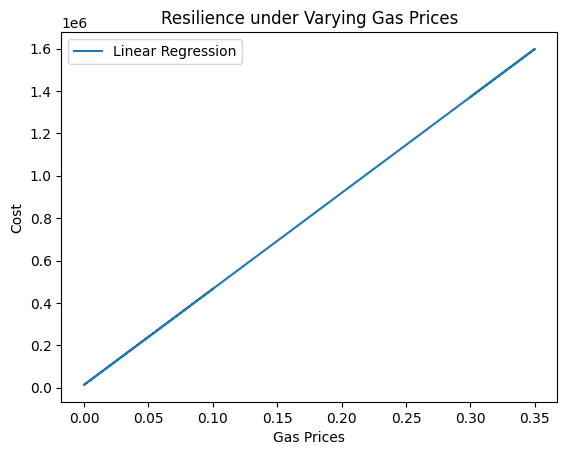

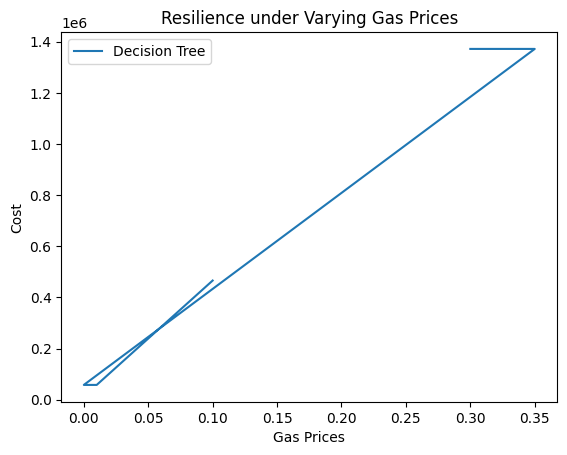

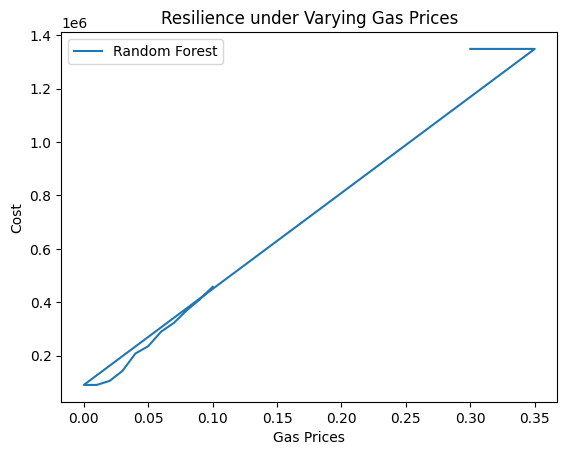

In [32]:
#plot predictions against costs for different ML models
#for the gas price variable
plot_resilience(lr_predictions, gas_variable, "Linear Regression")
plot_resilience(dt_predictions, gas_variable, "Decision Tree")
plot_resilience(rf_predictions, gas_variable, "Random Forest")

# PLOT FOR ALL MODELS TOGETHER

In [19]:
#Define a function to plot the cost und varying conditions per variable

def plot_resilience_all(variable):
    plt.figure(figsize=(5, 4))
    plt.plot(variable, lr_predictions, label="Linear Regression")
    plt.plot(variable, dt_predictions, label="Decision Tree")
    plt.plot(variable, rf_predictions, label="Random Forest")
    plt.xlabel("Gas Price")
    plt.ylabel("Cost")
    plt.legend()
    plt.title("Resilience under Varying Gas Prices")
    output_path = "plot_gas_price_all_models.png"  # Change the path and extension as needed
    plt.savefig(output_path, format='png', dpi=300)  # Save as PNG with 300 dpi resolution
    plt.show()


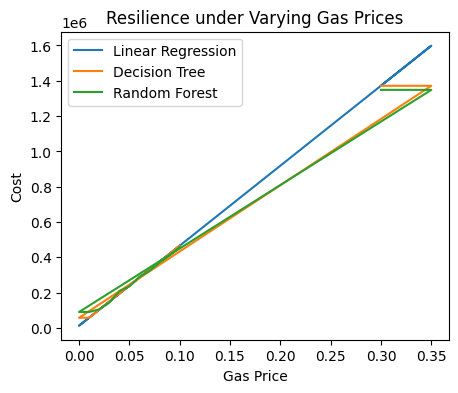

In [20]:
#Plot for all variables
plot_resilience_all(gas_variable)
